In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [24]:
import dataframe_image as dfi
import os

In [25]:
from IPython.display import display
p = print
d = display

In [26]:
def disp_to_file(df_, path):
  df = df_.replace(0, ' ')
  with open(path, "w") as f:
    df_styled = df.style
    dfi.export(df_styled, path)

  os.startfile(path, "print")

# Get the Hashi Table

In [27]:
fname = 'hashi2'
hashi = pd.read_excel(fname + '.xlsx', header=None)
hashi.fillna(0, inplace=True)
hashi = hashi.apply(pd.to_numeric, downcast='integer')
hashi = hashi
rows = len(hashi)
cols = len(hashi.columns)

h_org = hashi.copy()

disp_to_file(hashi, fname + '.png')

#solve_hashi()

In [28]:
def manual_hashi():
  global hashi
  hashi[0] = [1,0,4,0,2,0]
  hashi[1] = [0,0,0,2,0,3]
  hashi[2] = [4,0,7,0,1,0]
  hashi[3] = [0,0,0,2,0,5]
  hashi[4] = [0,0,3,0,1,0]
  hashi[5] = [3,0,0,3,0,3]

  hashi = pd.DataFrame(hashi).T
  rows = len(hash)
  cols = len(hash.columns)

  h_org = hashi.copy()

  d(hashi)
#manual_hashi()

# Modify Hashi

In [29]:
#hashi.iloc[4,2]=8
#hashi.iloc[5,3]=2
#hashi

In [30]:
DEBUG = False

In [31]:
nodes = {}
roads = {}
def make_nodes(hashi):
  n = -1
  for i in range(rows):
    node = None
    for j in range(cols):
      n += 1
      nodes[n] = (i,j)
      nodes[(i,j)] = n
      if hashi.iloc[i,j] == 0:
        continue
      if node is None:
        node = n
        node_val = hashi.iloc[i,j]
        continue
      if not (node_val == 1 and hashi.iloc[i,j] == 1):
        min_ = 2
        if (node_val == 2 and hashi.iloc[i,j] == 2):
          min_ = 1
        roads[node, n] = min(node_val, min(min_, hashi.iloc[i,j]))
      node = n
      node_val = hashi.iloc[i,j]
  # now the columns connections
  for j in range(cols):
    node = None
    for i in range(rows):
      n = i * cols + j
      if hashi.iloc[i,j] == 0:
        continue
      if node is None:
        node = n
        node_val = hashi.iloc[i,j]
        continue
      if not (node_val == 1 and hashi.iloc[i,j] == 1):
        min_ = 2
        if (node_val == 2 and hashi.iloc[i,j] == 2):
          min_ = 1
        roads[node, n] = min(node_val, min(min_, hashi.iloc[i,j]))
      node = n
      node_val = hashi.iloc[i,j]
  if DEBUG:
    p('Nodes:', nodes)
    p('\nRoads:\n')
    p(roads)
#make_nodes(hashi)  

In [32]:
from copy import deepcopy

links_org = None
def make_links():
  links = {}
#  p(roads)
#  p()
  for x, y in roads.keys():
      if x in links:
          links[x].append(y)
      else:
          links[x] = [y]
      if y in links:
          links[y].append(x)
      else:
          links[y] = [x]
  if DEBUG: p(links)
  links_org = deepcopy(links)
  return links, links_org
#links, links_org = make_links()
#p(links_org)
#hashi

## Plot

In [33]:
import matplotlib.transforms as transforms
def plot_trip(l):
  l_ = {}
  if DEBUG: p('in plot_trip', len(l.keys()), l)
  fig, ax = plt.subplots(dpi=144)
  plt.xlim(-1, rows)
  plt.ylim(cols, -1)

  for tup, n_conn in l.items():
    new_tup = (tup[1], tup[0])
    if new_tup in l_:  # skip duplicates
      continue
    l_[new_tup] = 0
    p1 = nodes[tup[0]]
    p2 = nodes[tup[1]]
    df = pd.DataFrame([p1, p2], index=['p1', 'p2'])
    line, = ax.plot(df[1], df[0], lw=1, color='black')#, lw= 2 * (lw * 2 - 1))

    ax.text(p1[1], p1[0], hashi.iloc[p1[0], p1[1]], 
         ha="center", va="center",
         bbox=dict(boxstyle="circle", facecolor='white', alpha=1, edgecolor='black')
         ) 
    
    if n_conn == 1:
      continue
    # shift the lines over 2 points
    # from site: https://matplotlib.org/2.0.2/users/transforms_tutorial.html
    dx = df[1][0] - df[1][1]
    dy = df[0][0] - df[0][1]
    if dx != 0:
      dy = 2/72
      dx = 0
    else:
      dy = 0
      dx = 2/72
    offset = transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    shadow_transform = ax.transData + offset

      # now plot the same data with our offset transform;
      # use the zorder to make sure we are below the line
    ax.plot(df[1], df[0], lw=1, color='black', transform=shadow_transform,  zorder=0.5*line.get_zorder())

  png_path = fname + '_plot.png'
  plt.savefig(png_path)
  plt.show()

  os.startfile(png_path, "print")  
#plot_trip(l)  

# DO the trip

In [34]:
class Node:
    def __init__(self, data):
        self.data = data
        self.next = None
        
class Stack:
    def __init__(self):
        self.head = None
 
    def push(self, data):
        if DEBUG: p('push', data)
        if self.head is None:
            self.head = Node(data)
        else:
            new_node = Node(data)
            new_node.next = self.head
            self.head = new_node
 
    def pop(self):
        if self.head is None:
            return None
        else:
            popped = self.head.data
            tmp = self.head.next
            del self.head
            self.head = tmp
            if DEBUG: p('pop', popped)
            return popped

In [35]:
queue = Stack()

def find_city(h):
       # try a city in the list which is has connections left
    if DEBUG: p('in find city')
    for i in range(rows * cols):
      if h.iloc[nodes[i]] > 0:
        if DEBUG: p('found city', i)
        return i
      
def is_road_blocked(h, tup, block=-90):
    node1, node2 = nodes[tup[0]], nodes[tup[1]]
    rows=[node1[0], node2[0]]
    cols=[node1[1], node2[1]]
    if rows[0] > rows[1]:
      rows[0], rows[1] = rows[1], rows[0]
    if cols[0] > cols[1]:
      cols[0], cols[1] = cols[1], cols[0]
    for r in range(rows[0], rows[1] + 1):
      for c in range(cols[0], cols[1] + 1):
        if h.iloc[r, c] <= block:
          return True
    return False
        
def get_next_city(start, l, h, round):
  if DEBUG: p("start", start, links[start], l, h.iloc[nodes[start]], 'round=', round)
  if DEBUG: d(h)
  for city in links[start]:
    if DEBUG: p('new city', city, l)
      # allow multiple times to connect between cities as long as it is not more than 2 connections
      # check if the connection between these 2 cities is already taken care of
    tup2 = (city, start)
    if tup2 in l:
      if DEBUG: p('check',l[tup2], city, start)
      if round == 0 or l[tup2] > 1:
        continue
    tup = (start, city)
    if tup in l:
      if DEBUG: p('check 2',l[tup], city, start)
      if round == 0 or l[tup] > 1:
        continue
      # check if city has connections left
    if DEBUG: p('remain', start, h.iloc[nodes[start]])
    if h.iloc[nodes[start]] == 0:
      continue  # end of chain, try another city
    if DEBUG: p('remain2', city, h.iloc[nodes[city]])
    if h.iloc[nodes[city]] == 0:
      continue  # can not use this city because no connection left, try another city
      # check if there is no block in the middle
    if is_road_blocked(h,tup):
      if DEBUG: p('blocked')
      continue
    if not tup in l: 
      l[tup] = 0
    if not tup2 in l: 
      l[tup2] = 0
#    n_conn = roads[(start, city)] if (start, city) in roads else roads[(city, start)]
#    l[start][1] = min(h.iloc[nodes[start]], n_conn)  # number of connections
    n_conn = 1
    l[tup] += n_conn
    l[tup2] += n_conn
    if l[tup] != l[tup2]:
      if DEBUG: p('ERROR: ', tup, tup2, l[tup], l[tup2])
      raise Exception
#    n_conn = l[start][1]
    h.iloc[nodes[start]] -= n_conn # connections left for the cities
    h.iloc[nodes[city]] -= n_conn # connections left for the cities
    if DEBUG: p("city", city, l)
    if DEBUG: d(h)
    return city
  if DEBUG: p('none')
  if round == 1:
    return find_city(h)
  return None  # end of chain, go back and find a prev city with connections not 0

l = {}

def trip():
  global h_fix
  def get_last():
    if DEBUG: p('in get_last')
    data = queue.pop()
    if data is None:  #queue is empty
      return None
    start = data
    lasts.pop()
    if DEBUG: p(start)
    return start
  
  def init(start):
    if DEBUG: d(h_fix)
    h = h_fix.copy()
    round = 0
    l = l_fix.copy()
    while queue.pop():
      pass
    if start is None:
      lasts = []
    else:
      lasts = [start]
      queue.push(start)
    return l, h, round, lasts
    
  n = rows * cols
  start = None
  if len(links.keys()) > 0:
    start = list(links.keys())[0]
  l, h, round, lasts = init(start)
  while h[h > 0].sum().sum() > 0:
    if DEBUG: p("lasts", start, round, lasts)
    city = get_next_city(start, l, h, round)
    if not city is None:
      if city == start:
          # no solution so remove the first link  and try another solution
        start = list(links.keys())[0]
        links[start].pop(0)
        if DEBUG: p("start again: ", start, links[start])
        while get_last() is None:
          pass 
        l, h, round, lasts = init(start)
        continue
        # is the new city has any connections left
      if h.iloc[nodes[city]] > 0:
        start = city
        queue.push(start)
        lasts.append(start)
        continue
      start = get_last()
      if start is None:
        start = find_city(h)
      continue
    start = get_last()
    if start == None:
      if round > 0:
        break
      round += 1
      start = list(links.keys())[0]
  p('finished: ', h[h > 0].sum().sum())
  return l

In [36]:
l_fix = None
h_fix = None

def make_l(l, n1, n2, n_conn):
  if n_conn > 0:
      tup = (n1, n2)
      tup2 = (n2, n1)
      if not tup in l: 
        l[tup] = 0
      if not tup2 in l: 
        l[tup2] = 0
      l[tup] += n_conn
      l[tup2] += n_conn

## find 3 or 4 with 2 connections only (usually in a corner)

In [37]:
def update_link(i, j, node, n_c, lk):
          h_fix.iloc[i,j] -= n_c
          tup_lk = nodes[lk]
          h_fix.iloc[tup_lk] -= n_c
          make_l(l_fix, node, lk, n_c)
          
def update_2links(i, j, node, n_conn, link):
        found2 = False
        for lk in link:
          tup = (node, lk)
          n_c = n_conn
            # check if not already in l_fix
          if tup in l_fix: 
            n_c -= l_fix[tup]
          update_link(i, j, node, n_c, lk)
            # special case - a city with 1, then the other connections (if the node is 5 or 3 must be 2 connections)
          tup_lk = nodes[lk]
          if n_conn == 1 and h_fix.iloc[tup_lk] == 0:
            found2 = True
          elif l_fix[tup] == 2: # if connections = 2 remove the link from the list
            links[lk].remove(node)
            if len(links[lk]) == 0:
              del links[lk]
        if (node in links) and h_fix.iloc[i,j] == 0:
            del links[node]
        if found2:
          for lk in link:
#            tup = (node, lk)
            tup_lk = nodes[lk]
            if h_fix.iloc[tup_lk] > 0:
#              n_c = 1
              update_link(i, j, node, 1, lk)              
#              h_fix.iloc[tup_lk] -= n_c
#              h_fix.iloc[i,j] -= n_c
#              make_l(l_fix, node, lk, n_c)         
                    # if connections = 2 remove the link from the list
              links[lk].remove(node)
              if len(links[lk]) == 0:
                del links[lk]
            if (node in links) and len(links[node]):
              del links[node]

In [38]:
def process_3_or_4(found, i, j, round, subtitle=''):
        if h_fix.iloc[i, j] <= 0:
          return found
        node = nodes[(i,j)]
        #DBG = True if node == 114 else False
        link = links_org[node] if round == 0 else links[node]
        if len(link) > 2:
          return found
        do_update = True
        sav_h =  h_fix.iloc[i,j]
        if round > 0 and len(links_org[node]) > 2:
          #if DEBUG or DBG: p(i, j, node, l_fix, '\n', links_org[node], link)
            # ignore node (3 or 4) that is already connected by 2 connections to another node 
            # and that is why it is down to 2 nodes left and not due to a block (not really a true corner)
          for lk in links_org[node]:
              tup = (node, lk)
              #if DEBUG or DBG: p('\t', tup, tup in l_fix)
              if tup in l_fix and l_fix[tup] == 2:
                #if DEBUG or DBG: p('\t\t', tup, l_fix[tup])
                return found
            # if node is left with 2 links only and has less than 3 connections left it does not qualify as a corner
          if len(link) == 2 and h_fix.iloc[i, j] < 2:
            return found
            # a case where it is not a corner case is when has 2 links, 2 connections left and no link yet between the 2 connections
            # unless one of the links has 1 connection left so we need to connect the current node to the other link with 1 connection at least
          if len(link) == 2 and h_fix.iloc[i, j] == 2:
            found2 = False
            for lk in link:
              tup = (node, lk)
              tup_lk = nodes[lk]
              if tup in l_fix:
                found2 = True
                break
              if h_fix.iloc[tup_lk] == 1: #add a connection to the other node
                lk = link[1] if lk == link[0] else link[0]
#                tup = (node, lk)
#                n_c = 1
                update_link(i, j, node, 1, lk)
#                h_fix.iloc[i,j] -= n_c
#                tup_lk = nodes[lk]
#                h_fix.iloc[tup_lk] -= n_c
#                make_l(l_fix, node, lk, n_c)
                found = found2 = True
                do_update = False
                break
            if not found2:
              return found
        n_conn = 1 if hashi.iloc[i, j] == 3 or h_fix.iloc[i, j] < 4 else 2
        if do_update:
          update_2links(i, j, node, n_conn, links[node])
        if sav_h != h_fix.iloc[i,j]:
          found = True
          tup0 = nodes[int(link[0])] 
          tup1 = nodes[int(link[1])]
          if DEBUG or DBG: p('found_3_or_4' + subtitle + ': ', i, j, node, link, tup0, tup1, sav_h, h_fix.iloc[i,j])
        return found

In [39]:
def find_3_or_4(round=0):
  if round == 0:
    find_7_or_8()
  found = False
  if DEBUG: p()
  sub_title = '' if round == 0 else f'_r{round}'
  for i in range(rows):
    for j in range(cols):
      if hashi.iloc[i, j] == 3 or hashi.iloc[i, j] == 4:
          found = process_3_or_4(found, i, j, round, sub_title)
  if DEBUG:
    if found:
      d(h_fix)
      p(l_fix)
      p()
      p('links:', links)
    else:
      p('Not found_3_or_4' + sub_title)

## find 5 or 6 on the side

In [40]:
def process_5_or_6(found, i, j, round, subtitle=''):
        if h_fix.iloc[i, j] <= 0:
          return found
        node = nodes[(i,j)]
        #DBG = True if node == 32 else False
        link = links_org[node] if round == 0 else links[node]
        if len(link) > 3:
          return found
        do_update = True       
        sav_h =  h_fix.iloc[i,j]
        if round > 0 and len(links_org[node]) > 3:
          #if DEBUG or DBG: p(i, j, node, l_fix, '\n', links_org[node], link)
            # if node is left with 2 links only and has more than 2 connections left need to connect 1 for each node (same as 3 in a corner)
          if len(link) == 2 and h_fix.iloc[i, j] <= 2:
            # ignore node (5 or 6) that is already connected by 2 connections to another node 
            # and that is why it is down to 2 nodes left and not due to a block (not really a true corner)
            # unless one of the links has 1 connection left so we need to connect the current node to the other link with 1 connection at least
            if len(link) == 2 and h_fix.iloc[i, j] == 2:  
  #            found2 = False
              for lk in link:
                tup = (node, lk)
                tup_lk = nodes[lk]
  #              if tup in l_fix:
  #                found2 = True
  #                break
                if h_fix.iloc[tup_lk] == 1: #add a connection to the other node
                  lk = link[1] if lk == link[0] else link[0]
                  update_link(i, j, node, 1, lk)
                  if DEBUG or DBG: p(i, j, node, link, '\n', l_fix)
                  found = found2 = True
                  do_update = False
                  break
  #            if not found2:
  #              return found
            else:
              for lk in links_org[node]:
                tup = (node, lk)
                if DEBUG or DBG: p('\t', tup, tup in l_fix)
                if tup in l_fix and l_fix[tup] == 2:
                  if DEBUG or DBG: p('\t\t', tup, l_fix[tup])
                  return found
        n_conn = 1 if hashi.iloc[i, j] == 5 else 2
        if do_update:
          update_2links(i, j, node, n_conn, links[node])
        if sav_h !=  h_fix.iloc[i,j]:
          found = True
          tup0 = nodes[int(link[0])] 
          tup1 = nodes[int(link[1])]
          tup2 = nodes[int(link[2])] if len(link) > 2 else None
          if DEBUG: p('found_5_or_6' + subtitle + ': ', i, j, node, link, tup0, tup1, tup2)
        return found

In [41]:
def find_5_or_6(round=0):
  find_3_or_4(round)
  if DEBUG: p()
  found = False
  
  sub_title = '' if round == 0 else f'_r{round}'
  for i in range(rows):
    for j in range(cols):
      if hashi.iloc[i, j] == 5 or hashi.iloc[i, j] == 6:
          found = process_5_or_6(found, i, j, round, sub_title)
          
  if DEBUG:
    if found:
      d(h_fix)
      p(l_fix)
      p()
      p('links:', links)
    else:
      p('Not found_5_or_6' + sub_title)

## find 7 or 8 in the middle

In [42]:
def find_7_or_8():
  if DEBUG: p()  
  found = False
  for i in range(1, rows-1):
    for j in range(1, cols-1):
      if hashi.iloc[i, j] >= 7:
        found = True
        node = nodes[(i,j)]
        link = links_org[node]
        tup0 = nodes[int(link[0])] 
        tup1 = nodes[int(link[1])] 
        tup2 = nodes[int(link[2])] 
        tup3 = nodes[int(link[3])] 
        if DEBUG: p('found_7_or_8:', i, j, node, link, tup0, tup1, tup2, tup3)
        n_conn = 1 if hashi.iloc[i, j] == 7 else 2
          # check if not already in l_fix
        found2 = False
        for lk in link:
          tup = (node, lk)
          n_c = n_conn
          if tup in l_fix: 
            n_c -= l_fix[tup]
          update_link(i, j, node, n_c, lk)            
#          h_fix.iloc[i,j] -= n_c
#          tup_lk = nodes[lk]
#          h_fix.iloc[tup_lk] -= n_c
#          p(n_c, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#          make_l(l_fix, node, lk, n_c)
            # special case - 7 connected to a city with 1, then the other 2 must be 2 connections
          tup_lk = nodes[lk]
          if n_conn == 1 and h_fix.iloc[tup_lk] == 0:
            found2 = True
        if found2:
          for lk in link:
            tup = (node, lk)
            tup_lk = nodes[lk]
            if h_fix.iloc[tup_lk] > 0:
#              n_c = 1
              update_link(i, j, node, 1, lk)              
#              h_fix.iloc[tup_lk] -= n_c
#              h_fix.iloc[i,j] -= n_c
#              p(n_c, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#              make_l(l_fix, node, lk, n_c)
                    # if connections = 2 remove the link from the list
#              p('\t', node, lk, links[lk])
              links[lk].remove(node)
              if len(links[lk]) == 0:
                del links[lk]
          del links[node]
  if DEBUG: 
    if found:
      d(h_fix)
      p(l_fix)
      p()
      p('links:', links)
    else:
      p('\nNot found_7_or_8\n')

## Special cases: 4 
>with 3 neighbours, one of them (or 2) with 1 connection, or with 2 neighbours (both must be 2 connections) or 3 neighbours 2 of them nodes of 2 (must have a connection to the 3rd otherwise an island)

In [54]:
def process_special4(found, h, i, j, subtitle=''):
        node = nodes[(i,j)]
        link = links_org[node]
        sav_h = h_fix.iloc[i,j]
        dbg_key = None
        if len(link) == 3:
          tup0 = nodes[int(link[0])] 
          tup1 = nodes[int(link[1])]
          tup2 = nodes[int(link[2])]
          if (h.iloc[tup0] == 2 and h.iloc[tup1] == 2) or (h.iloc[tup0] == 2 and h.iloc[tup2] == 2) or (h.iloc[tup2] == 2 and h.iloc[tup1] == 2):
            for index in range(3):  # if we have a (4) connected to few nodes, each with 2
              if index == 2 and (h.iloc[tup0] == 2 and h.iloc[tup1] == 2):
                tup_lk = tup2
              elif index == 1 and (h.iloc[tup0] == 2 and h.iloc[tup2] == 2):
                tup_lk = tup1
              elif index == 0 and (h.iloc[tup1] == 2 and h.iloc[tup2] == 2):
                tup_lk = tup0
              else:
                continue
              lk = link[index]
              tup = (node, lk)
              #p('\t', i, j, node, link, lk, index, tup, tup in l_fix, h_fix.iloc[tup0], h_fix.iloc[tup1], h_fix.iloc[tup2], h.iloc[tup0], h.iloc[tup1], h.iloc[tup2])
              if not tup in l_fix:
                update_link(i, j, node, 1, lk)                
#                n_c = 1
#                h_fix.iloc[tup_lk] -= 1
#                h_fix.iloc[i,j] -= 1
#                make_l(l_fix, node, lk, n_c)
                if DEBUG or node == dbg_key: p('found_special4 island' + subtitle + ': ', i, j, node, link, lk, tup_lk, tup, tup in l_fix, 
                                  tup0, tup1, tup2, h_fix.iloc[tup0], h_fix.iloc[tup1], h_fix.iloc[tup2])
          elif h.iloc[tup0] == 1 or h.iloc[tup1] == 1 or h.iloc[tup2] == 1: # check original values
            count = 0
            for lk in link:
              tup = (node, lk)
              tup_lk = nodes[lk]
              if h.iloc[tup_lk] == 1:
                  count += 1
                  continue
              if tup in l_fix:  # one node with 1 so must be connected to the other 2, but if already connected then we ignore than node
                continue
              if h_fix.iloc[tup_lk] > 0:  # found a node which is not 1 and not connected so need to connect
                update_link(i, j, node, 1, lk)
#                h_fix.iloc[tup_lk] -= 1
#                h_fix.iloc[i,j] -= 1
                if DEBUG or node == dbg_key: p('in special4_2', 1, i, j, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#                make_l(l_fix, node, lk, 1)
                # special case of 3 nodes connected to(4) and 2 of them are (1) so the 3rd must have 2 
                # connections with our node
            if count == 2:
              for lk in link:
                tup = (node, lk)
                tup_lk = nodes[lk]
                if h.iloc[tup_lk] == 1:
                  if tup in l_fix:
                    continue
                  if h_fix.iloc[tup_lk] > 0:
                    update_link(i, j, node, 1, lk)
#                    h_fix.iloc[tup_lk] -= 1
#                    h_fix.iloc[i,j] -= 1
                    if DEBUG or node == dbg_key: p('in special4_3', 1, i, j, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#                    make_l(l_fix, node, lk, 1)
                  continue
                n_c = 2      # complete to 2 connections
                  # check if not already in l_fix
                if tup in l_fix: 
                  n_c -= l_fix[tup]
                if n_c == 0:
                  continue
                update_link(i, j, node, n_c, lk)
#                h_fix.iloc[tup_lk] -= n_c
#                h_fix.iloc[i,j] -= n_c
                if DEBUG or node == dbg_key: p('in special4_4', n_c, i, j, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#                make_l(l_fix, node, lk, n_c)
            if sav_h != h_fix.iloc[i,j]:
              if DEBUG or node == dbg_key: p('found_special4 with 3' + subtitle + ': ', i, j, node, link, h_fix.iloc[i,j], tup0, tup1, tup2, 
                                             h_fix.iloc[tup0], h_fix.iloc[tup1], h_fix.iloc[tup2])
              found = True
          elif h_fix.iloc[tup0] == 1 or h_fix.iloc[tup1] == 1 or h_fix.iloc[tup2] == 1: # one node is 1 but not because of a connection to us
            if DEBUG or node == dbg_key: p('in special4: C', i, j, node, h_fix.iloc[tup0], h_fix.iloc[tup1], h_fix.iloc[tup2])
            count = 0
            for lk in link:
              tup = (node, lk)
              tup_lk = nodes[lk]
              if h_fix.iloc[tup_lk] == 1 and not tup in l_fix: # found a node with 1 and not connected to us -> must create a connection to the other 2
                count += 1
            if count > 0:  # found a node which is 1 and not connected so need to connect the other 2
              for lk in link:
                tup = (node, lk)
                tup_lk = nodes[lk]
                  # special case of 3 nodes connected to(4) and 2 of them are (1) so the 3rd must have 2 
                  # connections with our node
                if count == 2 and h_fix.iloc[tup_lk] != 1:
                  n_c = 2      # complete to 2 connections
                  if tup in l_fix: 
                    n_c -= l_fix[tup]                  
                  update_link(i, j, node, n_c, lk)
                elif count == 1 and not tup in l_fix and h_fix.iloc[tup_lk] > 1:
                  update_link(i, j, node, 1, lk)
            if sav_h != h_fix.iloc[i,j]:
              found = True
              if DEBUG or node == dbg_key: p('found in special4 node with 1', i, j, lk, count, h_fix.iloc[i,j], h_fix.iloc[tup0], h_fix.iloc[tup1], h_fix.iloc[tup2])
        elif len(link) == 2:
          for lk in link:
            tup = (node, lk) 
            tup_lk = nodes[lk]
            n_c = 2      # complete to 2 connections
              # check if not already in l_fix
            if tup in l_fix: 
              n_c -= l_fix[tup]
            if n_c == 0:
              continue
            update_link(i, j, node, n_c, lk)
#            h_fix.iloc[tup_lk] -= n_c
#            h_fix.iloc[i,j] -= n_c
            if DEBUG: p('in special4_5', n_c, i, j, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#            make_l(l_fix, node, lk, n_c)
          if sav_h != h_fix.iloc[i,j]:
            found = True
            if DEBUG or node == dbg_key: p('found_special4 with 2' + subtitle + ': ', i, j, node, link)
              
        return found

def find_special4(round=0):
  find_5_or_6(round)
  if DEBUG: p()
  found = False
  sub_title = '' if round == 0 else f'_r{round}'
  for i in range(rows):
    for j in range(cols):
      if hashi.iloc[i, j] == 4:
        found = process_special4(found, hashi, i, j)
  if DEBUG: 
    if found:
      d(h_fix)
      p(l_fix)
    else:
      p('Not found_special4' + sub_title)

## Special cases: 3 with 2 neighbours, one of them with 1 connection

In [44]:
def process_special3(found, h, i, j, round, subtitle=''):
        node = nodes[(i,j)]
        link = links_org[node] if round == 0 else links_org[node]
        if len(link) > 2:
          return found
        sav_h = h_fix.iloc[i,j]
        tup0 = nodes[int(link[0])] 
        tup1 = nodes[int(link[1])]
        for lk in link:
            tup = (node, lk)
            tup_lk = nodes[lk]
            if tup in l_fix:
              continue
            if h_fix.iloc[tup_lk] > 0:
                update_link(i, j, node, 1, lk)
#                h_fix.iloc[tup_lk] -= 1
#                h_fix.iloc[i,j] -= 1
                if DEBUG: p(1, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#                make_l(l_fix, node, lk, 1)
                # special case of 2 nodes connected to(3) and 1 of them is (1) so the 2nd must have 2 
                # connections with our node
        if h.iloc[tup0] == 1 or h.iloc[tup1] == 1:
            for lk in link:
                tup = (node, lk)
                tup_lk = nodes[lk]
                if h.iloc[tup_lk] == 1:
                  if tup in l_fix:
                    continue
                  if h_fix.iloc[tup_lk] > 0:
                    update_link(i, j, node, 1, lk)
#                    h_fix.iloc[tup_lk] -= 1
#                    h_fix.iloc[i,j] -= 1
                    if DEBUG: p(1, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#                    make_l(l_fix, node, lk, 1)
                  continue
                n_c = 2      # complete to 2 connections
                  # check if not already in l_fix
                if tup in l_fix: 
                  n_c -= l_fix[tup]
                if n_c == 0:
                  continue
                update_link(i, j, node, n_c, lk)
#                h_fix.iloc[tup_lk] -= n_c
#                h_fix.iloc[i,j] -= n_c
                if DEBUG: p(n_c, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#                make_l(l_fix, node, lk, n_c)
        if sav_h != h_fix.iloc[i,j]:
          if DEBUG: p('found_special3 with 2' + subtitle + ': ', i, j, node, link, tup0, tup1, h.iloc[tup0], h.iloc[tup1])
          found = True
        return found

def find_special3(round=0):
  find_special4(round)
  if DEBUG: p()
  found = False
  sub_title = '' if round == 0 else f'_r{round}'
  for i in range(rows):
    for j in range(cols):
      if hashi.iloc[i, j] == 3:
        found = process_special3(found, hashi, i, j, round, sub_title)
  if DEBUG: 
    if found:
      d(h_fix)
      p(l_fix)
    else:
      p('Not found_special3' + sub_title)

## Special cases: 2 with a neighbour value 1 or 2

In [45]:
DBG = False
def process_special2(found, i, j, round, subtitle=''):
        node = nodes[(i,j)]
        #DBG =  True if node == 136 else False
        link = links_org[node]
        if len(link) > 2:
          if len(link) == 3 and h_fix.iloc[i,j] == 2: # check for an island
            tup0 = nodes[int(link[0])] 
            tup1 = nodes[int(link[1])]
            tup2 = nodes[int(link[2])]
            h = hashi
            if (h.iloc[tup0] == 1 and h.iloc[tup1] == 1) or (h.iloc[tup0] == 1 and h.iloc[tup2] == 1) or (h.iloc[tup2] == 1 and h.iloc[tup1] == 1):
              tup_lk = tup0
              index = 0
              if (h.iloc[tup0] == 1 and h.iloc[tup1] == 1):
                tup_lk = tup2
                index = 2
              elif (h.iloc[tup0] == 1 and h.iloc[tup2] == 1):
                tup_lk = tup1
                index = 1
              lk = link[index]
              tup = (node, lk) 
              if not tup in l_fix:
                update_link(i, j, node, 1, lk)
#                n_c = 1
#                h_fix.iloc[tup_lk] -= 1
#                h_fix.iloc[i,j] -= 1
#                make_l(l_fix, node, lk, n_c)
                if DEBUG: p('found_special2 island' + subtitle + ': ', i, j, node, link, lk, tup_lk, tup, tup in l_fix, 
                                  tup0, tup1, tup2, h.iloc[tup0], h.iloc[tup1], h.iloc[tup2])
          if round == 0:
            return found
            # node of 2 with 3+ links originally
            # if node value is 1 we leave it for single() to take care of it 
            # but if here has 2 connections there is nothing more for us to check
          if h_fix.iloc[i,j] == 1:
            return found
        link = links[node]
        if len(link) > 2:
          return found
        sav_h = h_fix.iloc[i,j]
        tup0 = nodes[int(link[0])] 
        tup1 = nodes[int(link[1])]
        if hashi.iloc[tup0] <= 2 or hashi.iloc[tup1] <= 2:
          if hashi.iloc[tup0] <= 2: # must have a connection with the other node
            tup = tup1
            index = 1
          else:
            tup = tup0
            index = 0
          lk = link[index]  # link to the node with more than 2
          blocked = False
          if round > 0: 
            blocked = is_road_blocked(h_fix, (node, lk))
            if blocked and (node, lk) in l_fix:
              blocked = False
            if DBG: p('blocked:', node, lk, blocked, (node, lk) in l_fix)
            if not blocked:  # check if the 2nd link is blocked
              index_ = 1 - index
              lk_ = link[index_]
              blocked = is_road_blocked(h_fix, (node, lk_))
                # check for soft block
              if blocked and (node, lk_) in l_fix:
                blocked = False
              if DBG: p('blocked2:', node, lk_, blocked, (node, lk_) in l_fix)
              if False and blocked:
                index = index_
                lk = lk_
          if not blocked and (node, lk) in l_fix:
            return found
            # if 2 links and one is blocked then set node to 0
          n_c = 1
          if blocked and len(link) == 2:
            n_c = h_fix.iloc[i,j]
          update_link(i, j, node, n_c, lk)            
#          h_fix.iloc[tup] -= n_c
#          h_fix.iloc[i,j] -= n_c
          if DEBUG or DBG: p(n_c, i, j, node, link, lk, h_fix.iloc[i,j], sav_h, tup, tup0, hashi.iloc[tup0], tup1, hashi.iloc[tup1])
#          make_l(l_fix, node, lk, n_c)
          if h_fix.iloc[i,j] == 0:
            for lk in links_org[node]:
              if not lk in links:
                continue
              if DEBUG or DBG: p('remove', node, lk)
              links[lk].remove(node)
              if len(links[lk]) == 0:
                del links[lk]
            del links[node]
            
        if sav_h != h_fix.iloc[i,j]:
          if DEBUG or DBG: p('found_special2 with 2' + subtitle + ': ', i, j, node, link, h_fix.iloc[i,j], tup0, tup1, h_fix.iloc[tup0], h_fix.iloc[tup1])
          found = True
          if DBG: p(l_fix)
        return found

def find_special2(round=0):
  find_special3(round)
  if DEBUG: p()
  found = False
  sub_title = '' if round == 0 else f'_r{round}'
  for i in range(rows):
    for j in range(cols):
      if hashi.iloc[i, j] == 2 and h_fix.iloc[i, j] > 0:
        found = process_special2(found, i, j, round)
  if DEBUG or DBG: 
    if found:
      d(h_fix)
      p(l_fix)
    else:
      p('Not found_special2' + sub_title)

## Special cases: 6 with 4 neighbours, one of them (or 2) with 1 connection, or with 3 neighbours (all must be 2 connections)

In [46]:
def find_special6(round=0):
  find_special2(round)
  if DEBUG: p()
  found = False
  for i in range(rows):
    for j in range(cols):
      if hashi.iloc[i, j] == 6:
        node = nodes[(i,j)]
        link = links_org[node]
        if len(link) == 4:
          tup0 = nodes[int(link[0])] 
          tup1 = nodes[int(link[1])] 
          tup2 = nodes[int(link[2])]
          tup3 = nodes[int(link[3])]
          if hashi.iloc[tup0] == 1 or hashi.iloc[tup1] == 1 or hashi.iloc[tup2] == 1 or hashi.iloc[tup3] == 1:
            if DEBUG: p('found_special6 with 4:', i, j, node, link, tup0, tup1, tup2, tup3, 
                  hashi.iloc[tup0], hashi.iloc[tup1], hashi.iloc[tup2], hashi.iloc[tup3])
            found = True
            count = 0
            for lk in link:
              tup = (node, lk)
              tup_lk = nodes[lk]
              if hashi.iloc[tup_lk] == 1:
                count += 1
                continue
              if tup in l_fix:
                continue
              if h_fix.iloc[tup_lk] > 0:
                update_link(i, j, node, 1, lk)                
#                h_fix.iloc[tup_lk] -= 1
#                h_fix.iloc[i,j] -= 1
                if DEBUG: p(1, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#                make_l(l_fix, node, lk, 1)
                # special case of 4 nodes connected to(6) and 2 of them are (1) so the 3rd and 4th must have 2 
                # connections with our node
            if count == 2:
              for lk in link:
                tup = (node, lk)
                tup_lk = nodes[lk]
                if hashi.iloc[tup_lk] == 1:
                  if tup in l_fix:
                    continue
                  if h_fix.iloc[tup_lk] > 0:
                    update_link(i, j, node, n_c, lk)
#                    h_fix.iloc[tup_lk] -= 1
#                    h_fix.iloc[i,j] -= 1
                    if DEBUG: p(1, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#                    make_l(l_fix, node, lk, 1)
                  continue
                n_c = 2      # complete to 2 connections
                  # check if not already in l_fix
                if tup in l_fix: 
                  n_c -= l_fix[tup]
                if n_c == 0:
                  continue
                update_link(i, j, node, n_c, lk)
#                h_fix.iloc[tup_lk] -= n_c
#                h_fix.iloc[i,j] -= n_c
                if DEBUG: p(n_c, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#                make_l(l_fix, node, lk, 1)
        elif len(link) == 3:
          found = True
          if DEBUG: p('found_special6 with 3:', i, j, node, link)
          for lk in link:
            tup = (node, lk)
            tup_lk = nodes[lk]
            n_c = 2      # complete to 2 connections
              # check if not already in l_fix
            if tup in l_fix: 
              n_c -= l_fix[tup]
            if n_c == 0:
              continue
            update_link(i, j, node, n_c, lk)
#            h_fix.iloc[tup_lk] -= n_c
#            h_fix.iloc[i,j] -= n_c
            if DEBUG: p(n_c, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
#            make_l(l_fix, node, lk, n_c)
  if DEBUG: 
    if found:
      d(h_fix)
      p(l_fix)
    else:
      p('Not found_special6')

## remove links from cities with 0 connections left

In [47]:
def remove_zero_connections(round=0):
  if round >= 0:
    find_special6(round)
    if DEBUG: p()
  found = False
  for city in list(links.keys()):
    node = nodes[city]
    if h_fix.iloc[node] == 0:
      if not city in links:
        continue
      if DEBUG: p('found_remove_zero:',city, node, h_fix.iloc[node], links[city])
      found = True
      for c in links[city]:
        if not c in links:  # already removed
          continue
        link = links[c]
        link.remove(city)
        if DEBUG: p('\t', c, link)
        links[c] = link
        if len(link) == 0:
          del links[c]
      del links[city]
        # because links[] is modified we need to restart the loop
      remove_zero_connections(round=-1)
  if not DEBUG: return found
  if round == 0:
    if found:
      d(h_fix)
      p(l_fix)
    else:
      p('Not found_remove_zero') 
  return found

## Remove single connection

In [48]:
def remove_single(round=0):
  if round >= 0:
    remove_zero_connections(round)
    if DEBUG: p()
  found = False
  if DEBUG:
    p('links', links)
    p()
    p(list(links.keys()))
    p()
  for city in list(links.keys()):
    if len(links[city]) == 1:
      node1 = nodes[city]
      c = links[city][0]
      node2 = nodes[c]
      if DEBUG: p('found single:', city, links[city], node1, h_fix.iloc[node1], node2, h_fix.iloc[node2])
      found = True
      n_c = h_fix.iloc[node1]
      if n_c > 0:
        make_l(l_fix, city, c, n_c)
        h_fix.iloc[node2] -= n_c
        h_fix.iloc[node1] -= n_c
        if DEBUG: d(h_fix)
      link = links[c]
      link.remove(city)
      del links[city]
      if len(link) == 0:
        del links[c]
      if h_fix.iloc[node1] == 0 or h_fix.iloc[node2] == 0: 
        remove_zero_connections(round=-1)
      if DEBUG: p(l_fix)
        # because links[] is modified we need to restart the loop
      return remove_single(round=-1)
  if not DEBUG: return found
  if round == 0:    
    if found:
      d(h_fix)
      p(l_fix)
    else:
      p('Not found_single')
  return found

## Prepare blocked table

In [49]:
DBG = False
def prepare_blocked_table(round=0):
  global l_fix, h_fix
  if round >= 0:
    remove_single(round)
    l_fix = dict(sorted(l_fix.items()))
  h = h_fix.copy()
#  DBG = True
#  if DBG: d(h)
  if DEBUG and round == 0: p(l_fix)
  for tup in l_fix.keys():
    rows=[-1,-1]
    cols=[-1,-1]
    found = False
    for i in [0, 1]:
      node = nodes[tup[i]]
      if h_fix.iloc[node] == 0:
        rows[i] = node[0]
        cols[i] = node[1]
        found = True
    if not found:   #  mark "soft block" (no node is 0)
      for i in [0, 1]:
        node = nodes[tup[i]]
        rows[i] = node[0]
        cols[i] = node[1]
#      if DEBUG or DBG: p(tup, rows, cols, -90)
      if rows[0] == rows[1]:
        rows[1] += 1
        cols[0] += 1
      if cols[0] == cols[1]:
        cols[1] += 1
        rows[0] += 1
      for r in range(rows[0], rows[1]):
        for c in range(cols[0], cols[1]):
          h.iloc[r, c] = -90
      continue
    if -1 in rows or -1 in cols:
      index = 0 if rows[0] == -1 else 1
      index2 = 1 - index
      node = nodes[tup[index]]
      if rows[index2] == node[0]:   #same row
        rows[index] = rows[index2]
        if cols[index2] < node[1]:
          sav = cols[index2]
          cols[1] = node[1] - 1
          cols[0] = sav + 1
        else:
          cols[index] = node[1] + 1
        if cols[0] > cols[1]:
          cols[0], cols[1] = cols[1], cols[0]
      else:
        cols[index] = cols[index2]
        if rows[index2] < node[0]:
          sav = rows[index2]
          rows[1] = node[0] - 1
          rows[0] = sav + 1
        else:
          rows[index] = node[0] + 1
        if rows[0] > rows[1]:
          rows[0], rows[1] = rows[1], rows[0]
    for r in range(rows[0], rows[1] + 1):
      for c in range(cols[0], cols[1] + 1):
        h.iloc[r, c] = -99
  h_fix = h.copy()
    # now remove links that are "hard" blocked, or soft blocked without a link of the soft nodes
  for city, link in links.items():
    for lk in link:
      tup = (city, lk)
      blocked = is_road_blocked(h, tup, -99)
      if not blocked:
        blocked = is_road_blocked(h, tup)
        if blocked and tup in l_fix:
          blocked = False
      if blocked:
        if DEBUG or DBG or lk==136: p('blocked:', tup, city, lk, link, links[city], link == links[city])
        link.remove(lk)
        link = links[lk]
        link.remove(city)
  remove_single(round=-1) # not to do also all the other checks
#prepare_blocked_table(1)

## Check for islands

In [50]:
class NonBinTree:
    def __init__(self, val = None):
        self.val = val
        self.nodes = []
        self.list = []
        self.non_zero ={}
        if not val is None:
          self.add_city(val)
            
    def add_city(self, city):
      self.list.append(city)
      h = h_fix.iloc[nodes[city]]
      if h > 0:
        self.non_zero[city] = h
      
    def add_node(self, key, val):
      def add_list(node, val):
        for v in val:
          if not v in node.list:
            node.add_city(v)
            
      if self.val is None:
        self.val = key
        self.add_city(key)
        add_list(self, val)
        return
      nd = self
      n_nd = 0
      dbg_key = []#[85, 87]
      while True:
        if key in dbg_key: p('start of while loop', nd.val, self.val, key, val, nd.list, key in nd.list)
        if key in nd.list:
          add_list(nd, val)
          if key in dbg_key: p('start2 of while loop', nd.val, self.val, key, val, nd.list, key in nd.list)
          
            # verify if need to combine nodes
          for v in val:
            for node in nd.nodes:
              if key in dbg_key: p('start3 of while loop', nd.val, val, v, nd.nodes, node.val, node.list, v in node.list)
              if v in node.list:
                if key in dbg_key: p('start4 of while loop', nd.val, val, v, nd.nodes, node.val, node.list, v in node.list)
#                nd.add_node(node.val, node.list)
                add_list(nd, node.list)
                if key in dbg_key: p('start5 of while loop', nd.val, val, v, nd.nodes, node.val, node.list, v in node.list)
                nd.nodes.remove(node)
                if key in dbg_key: p('start6 of while loop', nd.val, val, v, nd.nodes, node.val, node.list, v in node.list)
                del node
                break
          
          if key in dbg_key: p('checking if need to combine lists due to adding val to a later list', nd.val, self.val, key, val)
            # verify if need to combine nodes (nodes after the current node in the list)
          if nd == self:  # this was already done above so no need to do it again
            return True
          idx = self.nodes.index(nd)
          if key in dbg_key: p('check combine - pass "self" test', nd.val, key, val, idx, len(self.nodes))
          for i in range(idx + 1, len(self.nodes)):
            node = self.nodes[i]
            if key in dbg_key: p(f'\tsearching in val={node.val} key={key}', node.list, key in node.list)
            found = False
            if key in node.list:
              found = True
            else:
              for v in val:
                if v in node.list:
                  found = True
                  break
            if found:
              if DEBUG: p('found in later list so combining', node.val, node.list, nd.val, nd.list)
#              nd.add_node(node.val, node.list)
              add_list(nd, node.list)
              if key in dbg_key: p(f'\tdoing combine in val={nd.val} key={key}', nd.list, self.nodes)
              self.nodes.remove(node)
              del node
              if key in dbg_key: p(f'\tafter doing combine in val={nd.val} key={key}', nd.list, self.nodes)
                
          return True
          # the key is not in the list now check the nodes in the val
        found = False
        for v in val:
          if v in nd.list:
              found = True
              break
        if found:
          nd.add_city(key)
          add_list(nd, val)
          
          if DEBUG: p('checking2 if need to combine lists due to adding val to a later list', nd.val, key, val, nd.list)
            # code moved to above - might need to duplicate it here too
          # the key is now in the nd.list so we go back to the start of the looop and this time the test 'key in nd.list' will be true
          continue
#          return True
           # none of the val is in the list so search on nodes of the master Tree only since we do not create sub nodes to the branches
        if len(self.nodes) > 0:
          if nd == self:
            nd = self.nodes[n_nd]
            continue
          if nd.val == self.nodes[n_nd].val:
            n_nd += 1
            if len(self.nodes) > n_nd:
              nd = self.nodes[n_nd]
              continue
        break
      new_node = NonBinTree()
      self.nodes.append(new_node)
      new_node.add_node(key, val)

    def __repr__(self):
        return f"(val={self.val}): list={self.list}, non_zero={self.non_zero}\n\tnodes = {self.nodes}"

In [51]:
def make_connected_node_list():
  l = {}
  t = [0,0]
  for t[0], t[1] in l_fix.keys():
    for i in [0,1]:
      if t[i] in l:
        if not t[i-1] in l[t[i]]:
          l[t[i]].append(t[1-i])
      else:
        l[t[i]] = [t[1-i]]
  return l

def make_tree():
  global DEBUG
  l = make_connected_node_list()
  l_list = list(l.keys())
  tree = NonBinTree()
  n = 0
  while len(l_list) > 0:
    city = l_list.pop(0)
    tree.add_node(city, l[city])
  return tree

In [52]:
def find_island():  
  tree = make_tree()
  nz = tree.non_zero
  if len(nz) > 1:
    for j in range(len(tree.nodes)):
      nz = tree.nodes[j].non_zero
      if len(nz) == 1:
        break
  found = False
  if len(nz) == 1:
    node, n_conn = list(nz.items())[0]
    link = links[node]
    for lk in link:
      tup = (node, lk)
      tup_lk = nodes[lk]
        # if one of the nodes has 1 connection originally it means we cannot connect to it otherwise we have an island
      if hashi.iloc[tup_lk] == 1:
        found = True
      elif n_conn == 1:
        #p(tree.nodes[j].val, node, link, lk, tup, tup_lk, tree.nodes[j])
          # check if another node has n_conn=1 and can be connected to this node, and thus the 2 will make an island
        for i in range(len(tree.nodes)):
          if i == j:
            continue
          nz_ = tree.nodes[i].non_zero
          if len(nz_) == 1: 
            node_, n_conn_ = list(nz_.items())[0]
            if n_conn_ == 1 and node_ in link:
              found = True
              #p(tree.nodes[i].val, node_, n_conn_, link, node_ in link)
              break
    if found:
        if DEBUG: p('found_island:', tup_lk, node, link, lk)
        if DEBUG: p(links)
        link.remove(lk)
        link = links[lk]
        link.remove(node)
  if DEBUG:
    p('tree: ',tree)
    if found:
      d(h_fix)
      p(l_fix)
    else:
      p('Not found_island')
  return tree
#find_island()

# Solve Hashi

Before:


,0,1,2,3,4,5
0,1,0,4,0,2,0
1,0,0,0,2,0,3
2,4,0,7,0,1,0
3,0,0,0,2,0,5
4,0,0,3,0,1,0
5,3,0,0,3,0,3


Sum =  0.0
finished:  0.0


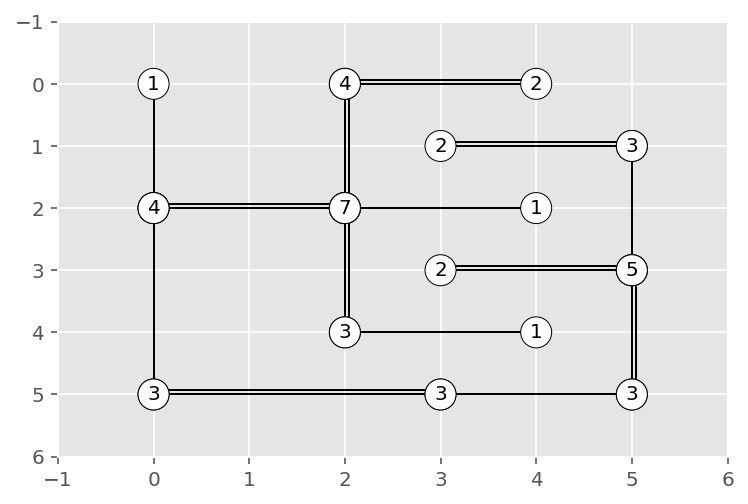

In [56]:
DEBUG = False
def solve_hashi():
  global DEBUG, l_fix, h_fix, links, links_org, links, roads, nodes
  l_fix = {}
  h_fix = hashi.copy()
  nodes = {}
  roads = {}
  make_nodes(h_fix)
  if DEBUG: p('make links')
  links, links_org = make_links()
  p('Before:')
  d(h_fix)

  #DEBUG = True

  prepare_blocked_table()
  if DEBUG: p('After')
  if DEBUG: d(h_fix)
  score = h_fix[h_fix > 0].sum().sum()
  p('Sum = ', score)
  if DEBUG:
    p('links:', links)
    p()
    p(list(links.keys()))
    p()
    p(l_fix)

  new_score = 0  
  while new_score != score and score > 0:  
    while new_score != score and score > 0:  
      new_score = score
      prepare_blocked_table(1)
      score = h_fix[h_fix > 0].sum().sum()
      p('Sum = ', score, new_score)

    find_island()
    prepare_blocked_table(1)
    score = h_fix[h_fix > 0].sum().sum()
    if DEBUG: p()
    p('Sum2 = ', score)

  if score == 0:
    plot_trip(trip())
    
solve_hashi()

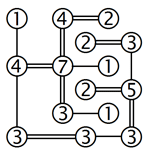

# Check Hashi (not completed (in case not solved before plot())

In [ ]:
  sav_h = h_fix.copy()
  sav_l = l_fix.copy()
  sav_links = links.copy()
  
  solution = trip()
  tree = make_tree()
  nz = tree.non_zero